In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# initialise the tensor graph and load the trained model
with tf.gfile.FastGFile('../resources/output_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [3]:
sess = tf.Session()
softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

In [4]:
# load labels
f = open('../resources/output_labels.txt', 'rb')
lines = f.readlines()

# prediciton of digits
def predict(digit):
    answer = []
    predictions = sess.run(softmax_tensor, {'DecodeJpeg:0': digit})
    predictions = np.squeeze(predictions)
    top = predictions.argsort()[-1:][::-1][0]
    scores = []
    labels = [str(w).replace("\n", "") for w in lines]
    return predictions[top], labels[top]

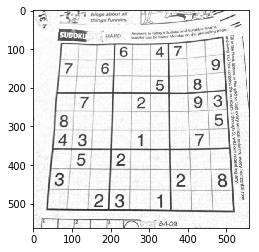

In [5]:
image = cv2.imread('../resources/sudoku1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

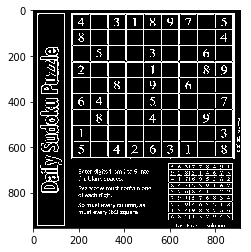

In [12]:
# Values for certain parameters have been chosen experimentally

# Thresholding
threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)

plt.imshow(threshold, cmap='gray')
plt.show()

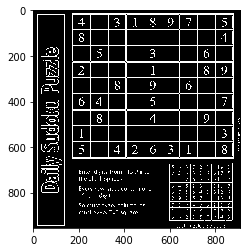

In [13]:
# Morphing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
eroded = cv2.erode(closing, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=1)

plt.imshow(eroded, cmap='gray')
plt.show()

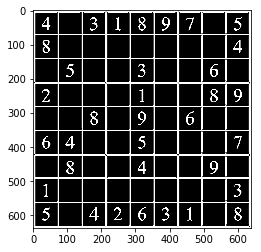

In [15]:
# get the sudoku grid
contours, h = cv2.findContours(np.copy(eroded), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

largest = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest)
cropped = eroded[y:y + h, x:x + w]

square_side = min(cropped.shape)
cropped = cv2.resize(cropped, (square_side, square_side))
cropped = cv2.dilate(cropped, cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2)), iterations=1)
plt.imshow(cropped, cmap='gray')
plt.show()

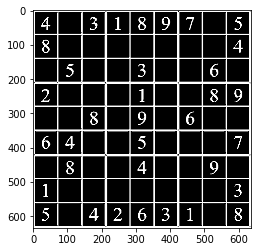

In [17]:
# Straighten the view (Bird's view), in case image is skewed
def four_point_transform(polygon, image):
    points = polygon.reshape(4, 2)
    
    sum = points.sum(axis=1)
    diff = np.diff(points, axis=1)
    
    top_left = points[np.argmin(sum)]
    top_right = points[np.argmin(diff)]
    bottom_right = points[np.argmax(sum)]
    bottom_left = points[np.argmax(diff)]
    
    corners = np.array([
        top_left,
        top_right,
        bottom_right,
        bottom_left
    ], dtype="float32")
    
    widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))

    heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    temp = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    transformed_matrix = cv2.getPerspectiveTransform(corners, temp)
    warp = cv2.warpPerspective(image, transformed_matrix, (maxWidth, maxHeight))
    return cv2.resize(warp, (min(warp.shape), min(warp.shape)))

polygon = None
contours, h = cv2.findContours(np.copy(cropped), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx_poly = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

    if len(approx_poly) == 4:
        polygon = approx_poly
        largest = contour
        break

sudoku = four_point_transform(polygon, cropped)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# sudoku = cv2.erode(sudoku, kernel, iterations=1)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
# sudoku = cv2.dilate(sudoku, kernel, iterations=1)
plt.imshow(sudoku, cmap='gray')
plt.show()

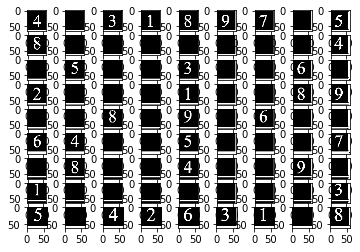

In [24]:
# Divide the sudoku grid in cells and extract digits
width, height = sudoku.shape

cells = []
cell_size = width/9
if width%9 != 0:
    cell_size += 1

for Y in range(0, height, cell_size):
    row = []
    for X in range(0, width, cell_size):
        cell = sudoku[Y+5:Y+cell_size, X+5:X+cell_size-5]
        
        plt.subplot(9, 9, (len(row) + 1) + (len(cells) * 9))
        plt.imshow(cell, cmap='gray')
        
        score_threshold, digit = predict(cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR))
        
        if score_threshold < 0.70:
            row.append(0)
        else:
            row.append(int(digit))
    cells.append(row)

plt.show()

In [25]:
# Now lets solve the sudoku :D
def check(sudoku_grid, row, col, num):
    boolRow, boolCol, boolBox = True, True, True
    
    for i in range(9):
        if sudoku_grid[row][i] == num:
            boolRow = False
            break
    
    for i in range(9):
        if sudoku_grid[i][col] == num:
            boolCol = False
            break
        
    row, col = row - row%3, col - col%3
    
    for i in range(3):
        for j in range(3):
            if sudoku_grid[i + row][j + col] == num:
                boolBox = False
                break
        if not boolBox:
            break
    
    return boolRow and boolCol and boolBox
 
def solve(sudoku_grid):
    row, col = -1, -1
    
    for i in range(9):
        for j in range(9):
            if sudoku_grid[i][j] == 0:
                row, col = i, j
                break
        if row != -1:
            break
    
    if row == -1:
        return True

    for num in range(1, 10):
        if(check(sudoku_grid, row, col, num)):
            sudoku_grid[row][col]=num
            if(solve(sudoku_grid)):
                return True
            sudoku_grid[row][col] = 0

    return False

solve(cells)

True

In [26]:
from pprint import pprint

pprint(cells)

[[4, 6, 3, 1, 8, 9, 7, 2, 5],
 [8, 7, 1, 6, 2, 5, 9, 3, 4],
 [9, 5, 2, 4, 3, 7, 8, 6, 1],
 [2, 3, 5, 7, 1, 6, 4, 8, 9],
 [7, 1, 8, 3, 9, 4, 6, 5, 2],
 [6, 4, 9, 8, 5, 2, 3, 1, 7],
 [3, 8, 7, 5, 4, 1, 2, 9, 6],
 [1, 2, 6, 9, 7, 8, 5, 4, 3],
 [5, 9, 4, 2, 6, 3, 1, 7, 8]]
